# MS024 Epoching
06/27/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re
import scipy

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS024'
subj_format = ['edf']
subj_site = ['MSSM']


### Import Preprocessed Data

In [5]:
mne_data_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', preload=True)

photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

In [6]:
mne_data_reref

<Raw | wm_ref_ieeg.fif, 123 x 898016 (1753.9 s), ~842.9 MB, data loaded>

In [7]:
photodiode_data

<Raw | photodiode.fif, 1 x 898016 (1753.9 s), ~6.9 MB, data loaded>

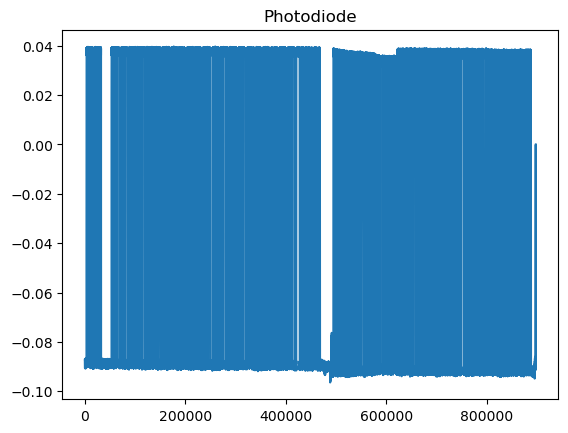

In [8]:
# Sanity check the photodiode
plt.plot(photodiode_data._data[0,])
plt.title("Photodiode")
plt.show()

### Load Anat Recon Info 


In [8]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,Notes
0,LaCaS1,A32sg_L,-9.585028,33.547612,-8.399996,-7.341464,29.783339,-10.461633,Gray,Left ACgG anterior cingulate gyrus,Area s32,L ACC,L CG,Left cingulate gyrus C,NaN,NaN
1,LaCaS2,A24rv_L,-10.383780,35.544494,-3.199996,-7.836954,32.391655,-5.187904,Gray,Left ACgG anterior cingulate gyrus,Area s32,L ACC,L CG,Left cingulate gyrus D,NaN,NaN
2,LaCaS3,A32sg_L,-11.182533,37.541376,1.200003,-8.565094,34.852447,-0.672995,White,Left Cerebral White Matter,Unknown,L ACC,L CG,Left cingulate gyrus E,NaN,NaN
3,LaCaS4,A32sg_L,-11.981285,39.138881,6.000003,-9.278688,36.919524,4.361672,White,Left Cerebral White Matter,Unknown,L ACC,L CG,Unknown,NaN,NaN
4,LaCaS5,A32p_L,-12.780038,40.736386,10.000003,-9.959662,38.999035,8.575860,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus F,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,RpTpT6,Unknown,41.535135,-42.333891,2.000003,47.333236,-46.351650,3.678801,White,Right Cerebral White Matter,Unknown,Unknown,Unknown,Right superior middle temporal gyrus F,NaN,NaN
154,RpTpT7,A39rv_R,45.928274,-43.532020,4.400003,51.611318,-47.097978,6.009020,Gray,Right Cerebral White Matter,Unknown,R Middle Temporal Gyrus,R IPL,Right superior middle temporal gyrus F,WM,NaN
155,RpTpT8,A39rv_R,49.522661,-44.330772,8.000003,55.038627,-47.328077,9.797899,Gray,Right MTG middle temporal gyrus,Unknown,R Middle Temporal Gyrus,R IPL,Right superior middle temporal gyrus F,NaN,NaN
156,RpTpT9,A39rv_R,53.915800,-45.528901,10.000003,59.330250,-48.095321,11.780442,Gray,Right MTG middle temporal gyrus,Area PGa (IPL),R Middle Temporal Gyrus,R IPL,Right superior middle temporal gyrus F,NaN,NaN


## Load behavior

In [9]:
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,weighted_low,p_g,p_s,util_rpe,util_tcpe,util_dcpe,util_tregret,util_dregret,util_trelief,util_drelief
0,1,10.0,mix,711.193594,711.202110,714.171474,714.179314,2.969365,0.0,-0.50,...,-1.935752,0.091555,0.908445,0.000000,-0.180789,-0.180789,-0.180789,-0.180789,0.000000,0.000000
1,2,58.0,gain,721.114148,721.114867,723.632947,725.649057,2.518079,0.2,0.00,...,0.000000,0.514599,0.485401,0.000000,0.000000,0.044672,0.000000,0.000000,0.406251,0.044672
2,3,114.0,loss,730.879285,730.890137,734.976974,736.992636,4.086837,-0.3,-0.67,...,-2.329102,0.650207,0.349793,2.329102,0.000000,2.803212,0.000000,0.000000,2.329102,2.803212
3,4,30.0,mix,747.719968,747.727200,750.451589,750.459211,2.724389,0.0,-1.50,...,-3.876350,0.009998,0.990002,0.000000,3.876350,3.876350,0.000000,0.000000,3.876350,3.876350
4,5,40.0,mix,757.963407,757.964198,760.196403,760.203295,2.232205,0.0,-0.50,...,-1.935752,0.132689,0.867311,0.000000,1.935752,1.935752,0.000000,0.000000,1.935752,1.935752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,63.0,gain,2435.413486,2435.414201,2437.190913,2439.206528,1.776712,0.3,0.00,...,0.000000,0.465674,0.534326,0.000000,0.000000,-0.105171,0.000000,0.000000,0.362031,-0.105171
146,147,135.0,loss,2444.444626,2444.451636,2452.432371,0.000000,0.000000,-0.5,-1.24,...,-3.436926,0.638360,0.361640,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
147,148,93.0,gain,2461.993719,2461.994448,2463.876889,2465.892385,1.882441,0.6,0.00,...,0.000000,0.446919,0.553081,0.000000,0.000000,-0.162992,0.000000,0.000000,0.561071,-0.162992
148,149,72.0,gain,2470.771141,2470.778802,2472.887488,2474.904123,2.108686,0.4,0.00,...,0.000000,0.450940,0.549060,-0.409808,-0.409808,-0.560370,-0.409808,-0.560370,0.000000,0.000000


In [10]:
beh_ts = behav_df['TrialOnset']

## Photodiode alignment

In [11]:
# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, 
                                            smoothSize=11, windSize=15, height=0.7)

23 blocks
.......................

found matches for 75 of 348 pulses
17 blocks
.................

found matches for 20 of 348 pulses


In [12]:
print(slope, offset)

0.886928480781943 -557.5507603007168


## Make epochs

In [13]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}


In [14]:

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0],
       'DecisionOnset': [0, 3.0]}

In [15]:
epochs_all_evs = {f'{x}': np.nan for x in evs}
epochs_all_baseline = {f'{x}': np.nan for x in evs}

In [16]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', 
                 elec_path=anat_file, 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, 
                 downsamp_factor=1, IED_args=IED_args)

    epochs_all_evs[event] = ev_epochs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 583 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 17642 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 18450 out of 18450 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 17826 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 18450 out of 18450 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend w

In [17]:
epochs_all_evs

{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~216.5 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 4 sec, baseline off, ~360.7 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

### Add metadata to epochs

In [18]:
for event in evs.keys():

    # Let's add our behavioral events to the metadata. Substitute this with the particulars for your behavioral dataframe. 

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    event_metadata['safe'] = behav_df['SafeBet'].tolist()
    event_metadata['low'] = behav_df['LowBet'].tolist()
    event_metadata['high'] = behav_df['HighBet'].tolist()
    event_metadata['profit'] = behav_df['Profit'].tolist()
    event_metadata['outcome'] = behav_df['Outcome'].tolist()
    #model-free vars
    event_metadata['g_ev'] = behav_df['GambleEV'].tolist()
    event_metadata['cr'] = behav_df['CR'].tolist()
    event_metadata['c_ev'] = behav_df['choiceEV'].tolist()
    event_metadata['rpe'] = behav_df['RPE'].tolist()
    event_metadata['tcpe'] = behav_df['totalCPE'].tolist()
    event_metadata['dcpe'] = behav_df['decisionCPE'].tolist()
    event_metadata['tregret'] = behav_df['totalRegret'].tolist()
    event_metadata['dregret'] = behav_df['decisionRegret'].tolist()
    event_metadata['trelief'] = behav_df['totalRelief'].tolist()
    event_metadata['drelief'] = behav_df['decisionRelief'].tolist()
    event_metadata['util_g'] = behav_df['util_g'].tolist()
    event_metadata['util_s'] = behav_df['util_s'].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

In [19]:
epochs_all_evs[event].metadata

,rmolf3,lacas4,lacas12,racas12,lmcms3,lmcms4,lmcms7,lmcms9,lmcms10,rmcms5,...,c_ev,rpe,tcpe,dcpe,tregret,dregret,trelief,drelief,util_g,util_s
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.20,-0.20,-0.20,-0.2,0.00,0.00,-1.754962,0.000000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.360,0.360,0.00,0.52,0.00,0.0,0.72,0.52,0.406251,0.361579
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.335,0.335,0.00,0.30,0.00,0.0,0.67,0.30,-2.329102,-2.803212
3,[1332],[1332],NaN,NaN,NaN,NaN,NaN,[1332],NaN,NaN,...,0.000,0.000,-0.60,-0.60,0.00,0.0,1.50,1.50,-3.514319,0.000000
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-1.00,-1.00,0.00,0.0,0.50,0.50,-1.435752,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.300,0.300,0.00,0.30,0.00,0.0,0.60,0.30,0.362031,0.467202
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.620,0.620,0.00,0.50,0.00,0.0,0.00,0.00,-3.436926,-3.871503
147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.600,0.600,0.00,0.60,0.00,0.0,1.20,0.60,0.561071,0.724063
148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.365,-0.365,-0.73,-0.40,-0.73,-0.4,0.00,0.00,0.409808,0.560370


### Save epoched data

In [20]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/epoch_{event}.fif', overwrite=True)